In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
from tqdm import tqdm
import time
import yaml
sys.path.append('../../../src')

import torch
import torch.nn.functional as F
from torch import tensor
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from common import common, transform, json
from common.json import IA_FORMAT, START_IDX
from common.functions import gauss, cos_similarity, standardize
from common.default import PASSING_DEFAULT
from individual_activity.individual_activity import IndividualActivity

In [2]:
device_idx = 0
device = f'cuda:{device_idx}' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

# Indivisual Activity をロード

In [3]:
data_settings = [
    {'room_num': '02', 'date': '20210903', 'option': 'passing'},
    {'room_num': '08', 'date': '20210915', 'option': 'passing'},
    {'room_num': '09', 'date': '20210706', 'option': 'passing'}
]

In [4]:
# homography
def get_homo(room_num):
    field_path = os.path.join(common.data_dir, '{}/field.png'.format(room_num))
    field_raw = cv2.imread(field_path)
    p_video = transform.homo[room_num][0]
    p_field = transform.homo[room_num][1]
    homo = transform.Homography(p_video, p_field, field_raw.shape)
    return homo

In [5]:
def load_individuals(json_data, prefix, homo):
    individuals = {}
    for data in json_data:
        label = prefix + str(data[IA_FORMAT[0]])
        frame_num = data[IA_FORMAT[1]]
        tracking_point = data[IA_FORMAT[2]]
        keypoints = data[IA_FORMAT[3]]

        if label not in individuals:
            ia = IndividualActivity(label, homo)
            individuals[label] = ia
        else:
            ia = individuals[label]

        ia.tracking_points[frame_num] = tracking_point
        ia.keypoints[frame_num] = keypoints
        for f in IA_FORMAT[START_IDX:]:
            ia.indicator_dict[f][frame_num] = data[f]
            
    return individuals

In [6]:
individuals = {}
for setting in data_settings:
    print(setting)
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    homo = get_homo(room_num)
    
    if opt is None:
        dir_path = f'{common.data_dir}/{room_num}/{date}/*'
    else:
        dir_path = f'{common.data_dir}/{room_num}/{date}/{opt}/*'
    dirs = glob.glob(dir_path)
    dirs = sorted(dirs)[:-1]  # delete make_csv.csv
    
    for path in tqdm(dirs):
        path = f'{path}/json/individual_activity.json'
        json_data = json.load(path)
        prefix = common.split_path(path)[-6] + '_' + common.split_path(path)[-3] + '_'  # room-num_date_
        individuals.update(load_individuals(json_data, prefix, homo))

{'room_num': '02', 'date': '20210903', 'option': 'passing'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  7.80it/s]


{'room_num': '08', 'date': '20210915', 'option': 'passing'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:03<00:00, 11.27it/s]


{'room_num': '09', 'date': '20210706', 'option': 'passing'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.99it/s]


# 特徴量抽出とデータ生成

In [7]:
def extract_features(frame_num, label1, label2, individuals):
    if label1 not in individuals or label2 not in individuals:
        return None
        
    individual1 = individuals[label1]
    pos1 = individual1.get_indicator('position', frame_num)
    body1 = individual1.get_indicator('body_vector', frame_num)
    arm1 = individual1.get_indicator('arm_ext', frame_num)
    wrist1 = [
        individual1.get_keypoints('LWrist', frame_num),
        individual1.get_keypoints('RWrist', frame_num)
    ]
    if pos1 is None or body1 is None or arm1 is None or None in wrist1:
        return None
    
    individual2 = individuals[label2]
    pos2 = individual2.get_indicator('position', frame_num)
    body2 = individual2.get_indicator('body_vector', frame_num)
    arm2 = individual2.get_indicator('arm_ext', frame_num)
    wrist2 = [
        individual2.get_keypoints('LWrist', frame_num),
        individual2.get_keypoints('RWrist', frame_num)
    ]
    if pos2 is None or body2 is None or arm2 is None or None in wrist2:
        return None
    
    # ポジション間の距離
    norm = np.linalg.norm(np.array(pos1) - np.array(pos2), ord=2)
    distance_prob = gauss(
        norm,
        mu=PASSING_DEFAULT['gauss_mu'],
        sigma=PASSING_DEFAULT['gauss_sig_min']
    )
    
    # 体の向き
    pos1 = np.array(pos1)
    pos2 = np.array(pos2)
    p1p2 = pos2 - pos1
    p2p1 = pos1 - pos2
    p1_sim = cos_similarity(body1, p1p2)
    p2_sim = cos_similarity(body2, p2p1)
    body_direction = (np.average([p1_sim, p2_sim]) + 1) / 2  # [-1, 1] -> [0, 1]
    
    # 腕の上げ下げ
    arm_ave = np.average([arm1, arm2])
    
    # 手首の距離
    min_norm = np.inf
    for i in range(2):
        for j in range(2):
            norm = np.linalg.norm(
                np.array(wrist1[i]) - np.array(wrist2[j]), ord=2)
            if norm < min_norm:
                min_norm = norm
    distance_prob_wrist = gauss(
        min_norm,
        mu=PASSING_DEFAULT['wrist_gauss_mu'],
        sigma=PASSING_DEFAULT['wrist_gauss_sig_min']
    )

    return [distance_prob, body_direction, arm_ave, distance_prob_wrist]

columns = ['distance', 'body direction', 'arm average', 'wrist distance']

In [8]:
x_dict = {}
y_dict = {}
for setting in data_settings:
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    dirs = sorted(glob.glob(f'{common.data_dir}/{room_num}/{date}/{opt}/*'))
    if dirs[-1].endswith('make_csv.csv'):
        dirs = dirs[:-1]

    for path in dirs:
        file_num = common.split_path(path)[-1]
        csv_path = f'{path}/csv/data.csv'
        csv_data = np.loadtxt(csv_path, delimiter=',', dtype=int, skiprows=1)

        for row in tqdm(csv_data, desc=f'{room_num}, {date}, {file_num}'):
            frame_num = row[0]
            label1 = f'{room_num}_{file_num}_{row[1]}'
            label2 = f'{room_num}_{file_num}_{row[2]}'

            features = extract_features(frame_num, label1, label2, individuals)
            key = f'{room_num}_{file_num}_{row[1]}_{row[2]}'

            if key not in x_dict:
                x_dict[key] = []
                y_dict[key] = []

            x_dict[key].append(features)
            y_dict[key].append(row[3])

09, 20210706, 09: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2833/2833 [00:00<00:00, 9767.59it/s]


## nanを穴埋めする

## pass以外の人を削除

In [9]:
len_pass = len([key for key, y_lst in y_dict.items() if 1 in y_lst])
len_not_pass = len([key for key, y_lst in y_dict.items() if 1 not in y_lst])

print(f'passing: {len_pass}')
print(f'not passing: {len_not_pass}')

passing: 68
not passing: 7908


In [10]:
y_lst_all = []
for y_lst in y_dict.values():
    y_lst_all += y_lst

len_pass = len([i for i in y_lst_all if i == 1])
len_not_pass = len([i for i in y_lst_all if i == 0])

print(f'all length:{len(y_lst_all)}')
print(f'passing: {len_pass}')
print(f'not passing: {len_not_pass}')

all length:452523
passing: 2059
not passing: 450464


# 深層学習

In [11]:
SIZE = len(list(x_dict.values())[0][0])
SEQ_LEN = 16

# leraning rate
LR = 0.001
LR_RATE = 0.99

# pos weight
POS_WEIGHT = [1., 2.]

# training and data settings
EPOCH = 50
BATCH_SIZE = 1024 * 4
TRAIN_RATIO = 0.65
VAL_RATIO = 0.05

config = {
    'seq_len': SEQ_LEN,
    'size': SIZE,
    'n_rnns': 2,
    'rnn_hidden_dim': 256,
    'rnn_dropout': 0.1,
    'n_linears': 2,
    'hidden_dims': [128, 8],
    'dropouts': [0.1, 0],
    'n_classes': 2,
    'lr': LR,
    'lr_rate': LR_RATE,
    'pos_weight': POS_WEIGHT,
    'epoch': EPOCH,
    'batch_size':BATCH_SIZE,
    'device': device,
}

# setting random seed
SEED = 64
np.random.seed(SEED)
torch.manual_seed(SEED)

## データセット生成

In [12]:
def create_sequence(x_lst, y_lst, **config):
    seq_len = config['seq_len']
    size = config['size']
    x_seq = []
    y_seq = []
    for i in range(len(x_lst) - seq_len + 1):
        x = x_lst[i:i + seq_len]
        x_seq.append(x)
        y_seq.append(y_lst[i + seq_len - 1])
    
    return x_seq, y_seq


class MyDataset(Dataset):
    def __init__(self, x_dict, y_dict, **kwargs):
        self.x, self.y = [], []
        for key in tqdm(x_dict.keys()):
            x_lst = x_dict[key]
            y_lst = y_dict[key]
            x_seq, y_seq = create_sequence(x_lst, y_lst, **config)
            self.x += x_seq
            self.y += y_seq
            
        self.device = kwargs['device']
            
    def __getitem__(self, index):
        return (
            tensor(self.x[index]).float().to(self.device),
            tensor(np.identity(2)[self.y[index]]).float().to(self.device)  # one-hot
        )

    def __len__(self):
        return len(self.x)

In [13]:
train_len = int(len(x_dict) * TRAIN_RATIO)
val_len = int(len(x_dict) * VAL_RATIO)

random_keys = np.random.choice(
    list(x_dict.keys()),
    size=len(x_dict),
    replace=False
)

train_keys = random_keys[:train_len]
val_keys = random_keys[train_len:train_len + val_len]
test_keys = random_keys[train_len + val_len:]

x_train_dict = {key: x_dict[key] for key in train_keys}
y_train_dict = {key: y_dict[key] for key in train_keys}
train_dataset = MyDataset(x_train_dict, y_train_dict, **config)
print(len(train_dataset))
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

x_val_dict = {key: x_dict[key] for key in val_keys}
y_val_dict = {key: y_dict[key] for key in val_keys}
val_loader = DataLoader(
    MyDataset(x_val_dict, y_val_dict, **config),
    shuffle=False
)

x_test_dict = {key: x_dict[key] for key in test_keys}
y_test_dict = {key: y_dict[key] for key in test_keys}
test_loader = DataLoader(
    MyDataset(x_test_dict, y_test_dict, **config),
    shuffle=False
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5184/5184 [00:01<00:00, 3918.46it/s]


248651


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2394/2394 [00:00<00:00, 39418.08it/s]


## モデル作成

In [14]:
class RNNModel(nn.Module):
    def __init__(self, **config):
        super(RNNModel, self).__init__()

        # init rnn layers
        in_dim = config['size']
        out_dim = config['rnn_hidden_dim']
        n_rnns = config['n_rnns']
        rnn_dropout = config['rnn_dropout']
        self.rnn = nn.LSTM(
            in_dim, out_dim,
            num_layers=n_rnns,
            dropout=rnn_dropout,
            batch_first=True
        )
        
        # init linear layers
        self.linears = nn.Sequential()
        for i in range(config['n_linears']):
            if i == 0:
                in_dim = config['rnn_hidden_dim']
            else:
                in_dim = config['hidden_dims'][i - 1]

            out_dim = config['hidden_dims'][i]
            dropout = config['dropouts'][i]
            self.linears.add_module(
                f'fc{i + 1}',
                Linear(in_dim, out_dim, dropout)
            )

        # init output layers
        self.output_layer = nn.Linear(config['hidden_dims'][-1], config['n_classes'])
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x, (_, _) = self.rnn(x)
        x = x[:, -1, :]
        x = self.linears(x)
        x = self.output_layer(x)
        x = self.softmax(x)
        
        return x


class Linear(nn.Sequential):
    def __init__(self, in_dim, out_dim, dropout):
        super(Linear, self).__init__(
            nn.Linear(in_dim, out_dim),
            nn.BatchNorm1d(out_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout)
        )

In [15]:
model = None
torch.cuda.empty_cache()

model = RNNModel(**config)
model = model.to(device)

model

RNNModel(
  (rnn): LSTM(4, 256, num_layers=2, batch_first=True, dropout=0.1)
  (linears): Sequential(
    (fc1): Linear(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
    )
    (fc2): Linear(
      (0): Linear(in_features=128, out_features=8, bias=True)
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0, inplace=False)
    )
  )
  (output_layer): Linear(in_features=8, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [16]:
pos_weight = torch.tensor(POS_WEIGHT).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: LR_RATE ** epoch)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=70, gamma=0.1)

## 学習

In [17]:
history = dict(train=[], val=[])
for epoch in range(1, EPOCH + 1):
    ts = time.time()

    # train
    model = model.train()
    train_losses = []
    lr = optimizer.param_groups[0]['lr']
    for x, y in train_loader:
        optimizer.zero_grad()

        pred = model(x)

        loss = criterion(pred.requires_grad_(), y)
        loss.backward()
        train_losses.append(loss.item())
        
        optimizer.step()
        
    scheduler.step()

    # validate
    model = model.eval()
    val_losses = []
    with torch.no_grad():
        for x, y in val_loader:
            pred = model(x)
            
            loss = criterion(pred.requires_grad_(), y)
            val_losses.append(loss.item())

    te = time.time()
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    history['train'].append(train_loss)
    history['val'].append(val_loss)

    print(f"Epoch[{epoch}/{(EPOCH)}] train loss: {train_loss:.5f}, val loss: {val_loss:.5f}, lr: {lr:.7f}, time: {te - ts:.2f}")

Epoch[1/50] train loss: 0.57987, val loss: 0.55534, lr: 0.0010000, time: 96.63
Epoch[2/50] train loss: 0.49511, val loss: 0.47558, lr: 0.0009900, time: 90.67
Epoch[3/50] train loss: 0.44254, val loss: 0.42900, lr: 0.0009801, time: 95.80
Epoch[4/50] train loss: 0.41040, val loss: 0.41217, lr: 0.0009703, time: 95.37
Epoch[5/50] train loss: 0.39300, val loss: 0.40536, lr: 0.0009606, time: 92.90
Epoch[6/50] train loss: 0.38341, val loss: 0.39217, lr: 0.0009510, time: 97.20
Epoch[7/50] train loss: 0.37793, val loss: 0.38739, lr: 0.0009415, time: 90.48
Epoch[8/50] train loss: 0.37461, val loss: 0.38554, lr: 0.0009321, time: 92.53
Epoch[9/50] train loss: 0.37213, val loss: 0.38210, lr: 0.0009227, time: 93.65
Epoch[10/50] train loss: 0.37079, val loss: 0.38029, lr: 0.0009135, time: 90.79
Epoch[11/50] train loss: 0.37001, val loss: 0.38446, lr: 0.0009044, time: 95.75
Epoch[12/50] train loss: 0.36858, val loss: 0.37914, lr: 0.0008953, time: 97.50
Epoch[13/50] train loss: 0.36829, val loss: 0.378

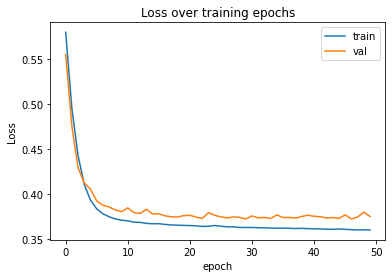

In [18]:
plt.plot(history['train'])
plt.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title('Loss over training epochs')
plt.legend(['train','val'])
plt.show()

## 検証

09_06_2_10


C:\Users\k2111\AppData\Local\Temp/ipykernel_1664/2918447074.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  x = torch.Tensor(x).float().to(device)


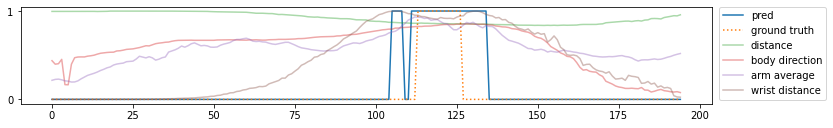

02_19_0_4


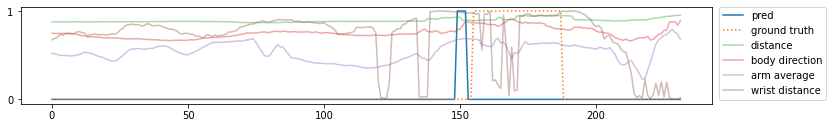

09_05_8_13


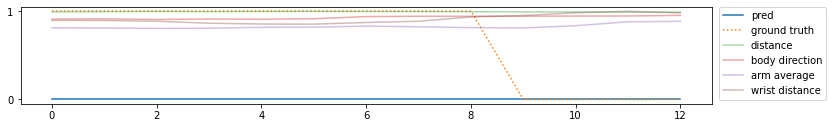

02_05_0_4


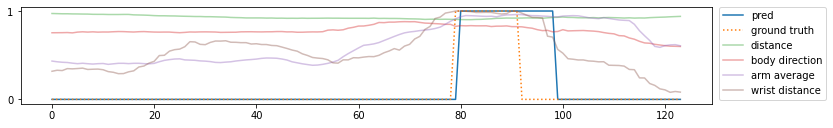

08_23_0_4


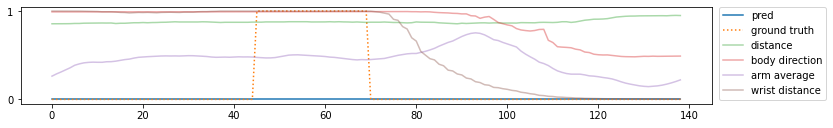

08_39_0_1


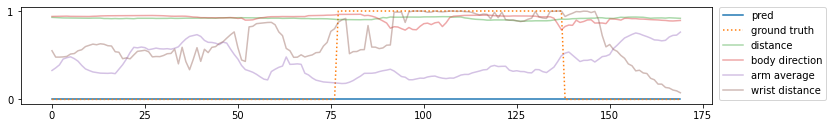

08_08_0_1


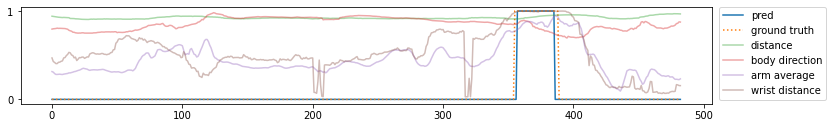

08_33_0_1


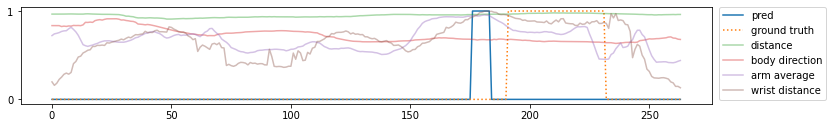

08_19_4_10


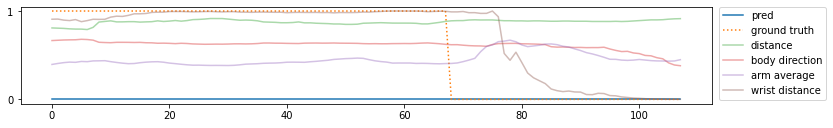

09_04_3_8


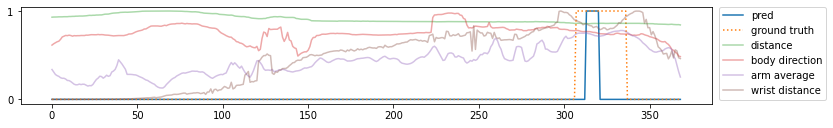

08_20_1_7


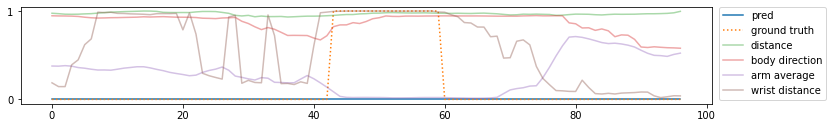

08_09_0_2


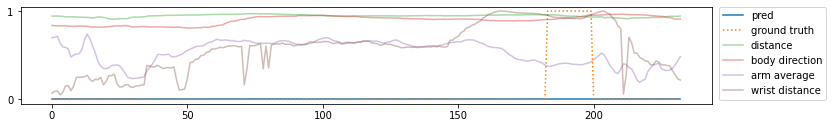

08_11_1_20


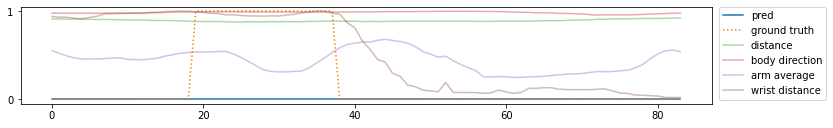

09_01_0_4


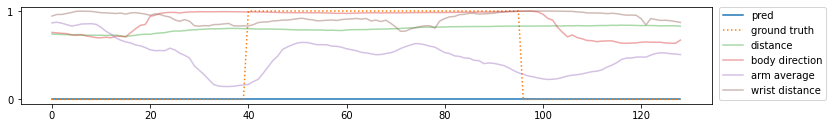

02_09_5_6


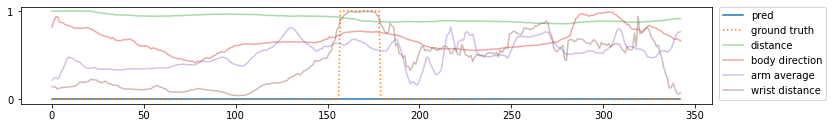

08_40_0_1


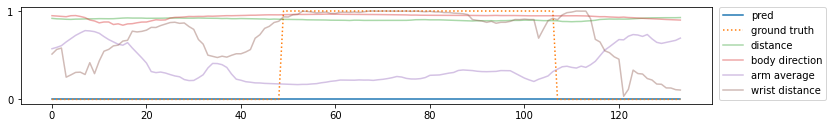

08_26_2_8


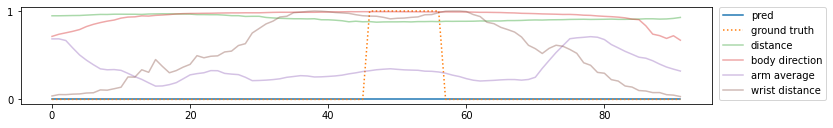

08_01_2_3


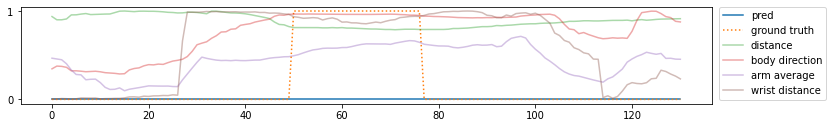

08_05_2_3


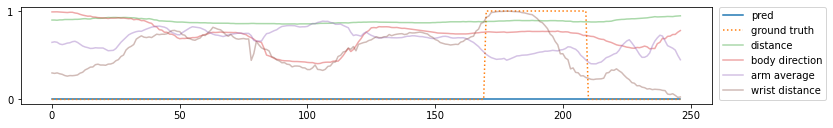

02_08_0_5


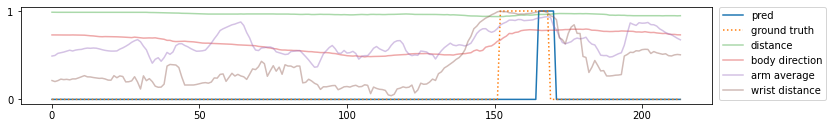

02_02_0_7


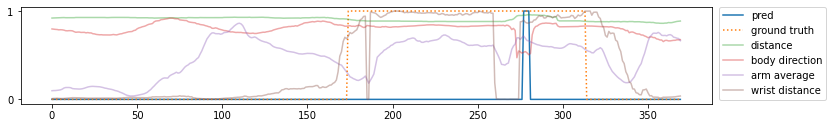

08_06_0_3


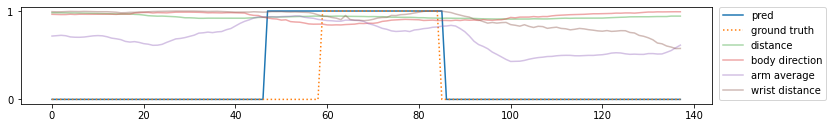

08_15_1_2


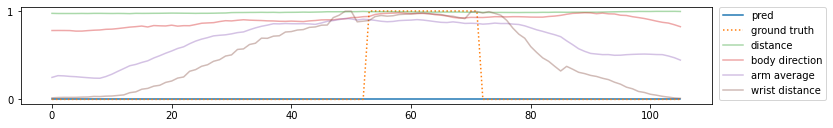

02_23_3_12


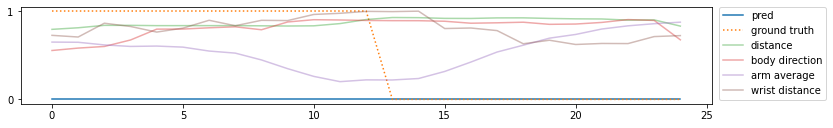

08_36_0_1


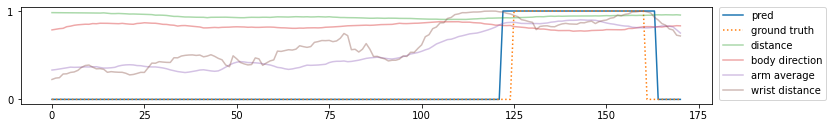

08_18_1_2


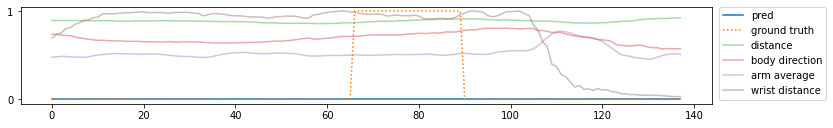

08_21_1_3


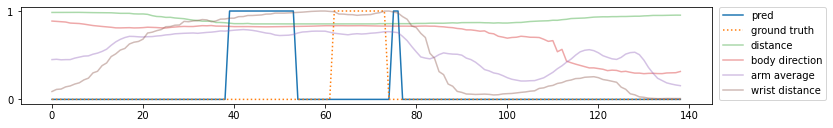

02_22_0_8


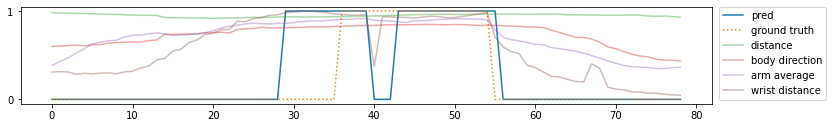

08_27_1_11


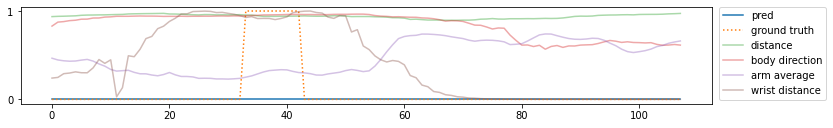

02_04_6_7


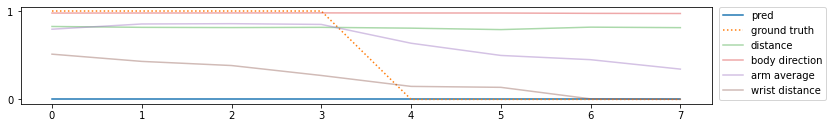

02_13_5_18


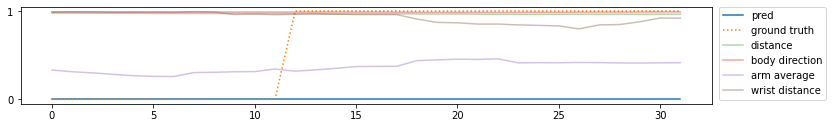

08_41_1_2


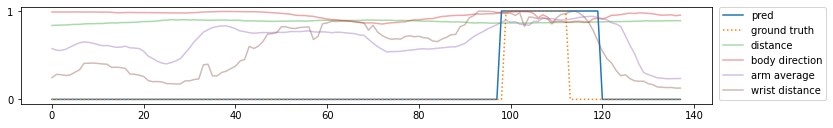

02_10_3_21


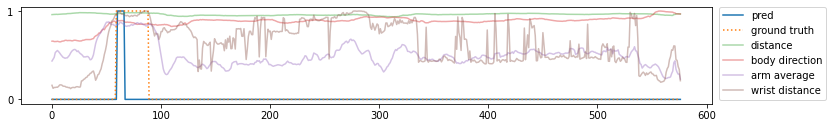

08_07_2_4


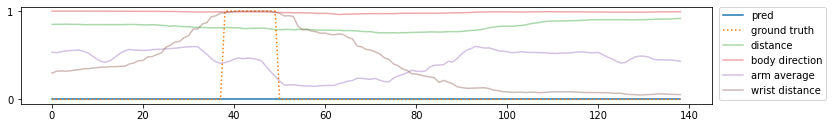

02_07_2_6


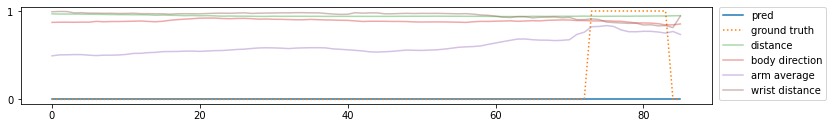

02_06_1_3


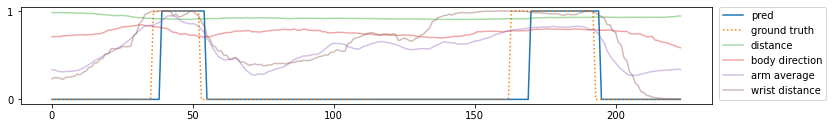

02_21_5_7


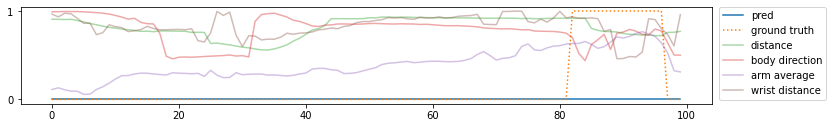

08_25_5_14


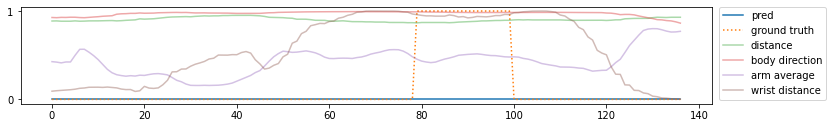

02_20_4_10


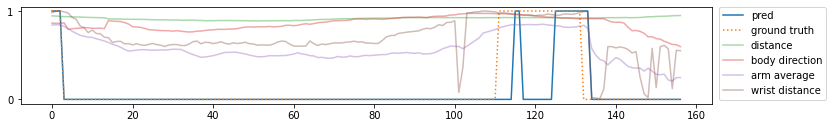

08_10_0_2


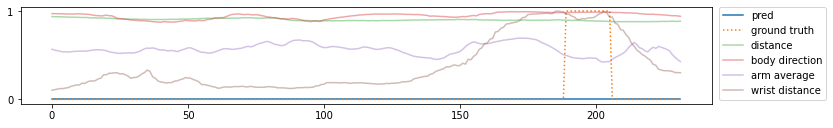

09_03_6_8


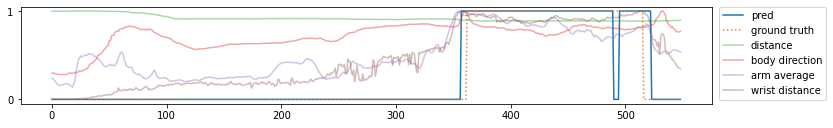

08_16_0_3


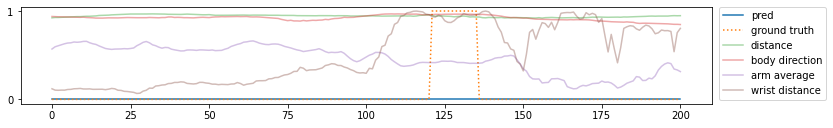

In [19]:
y_all_train = []
pred_all_train = []

model.eval()
with torch.no_grad():
    for key in train_keys:
        x_lst = np.array(x_dict[key])
        y_lst = y_dict[key]
        
        x, _ = create_sequence(x_lst, y_lst, **config)
        x = torch.Tensor(x).float().to(device)
        
        if len(x) == 0:
            continue

        pred = model(x)
        pred = pred.max(1)[1]
        pred = pred.cpu().numpy()

        x_lst = x_lst[SEQ_LEN - 1:]
        y_lst = y_lst[SEQ_LEN - 1:]
            
        y_all_train += y_lst
        pred_all_train += pred.tolist()
        
        if 1 not in y_lst:
            continue
            
        print(key)
        plt.figure(figsize=(10, 1.5))
        # plt.rcParams["font.size"] = 20
        # plt.rcParams["font.family"] = 'Times New Roman'
        plt.plot(pred, label='pred')
        plt.plot(y_lst, linestyle=':', label='ground truth')
        for i, x in enumerate(x_lst.T):
            plt.plot(x, alpha=0.4, label=columns[i])
        plt.ylim((-0.05, 1.05))
        plt.yticks([0, 1])
        plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
        plt.subplots_adjust(left=0.04, right=1, bottom=0.1, top=1)

        plt.show()

In [20]:
print('accuracy: {:.3f}'.format(accuracy_score(y_all_train, pred_all_train)))
print('precision: {:.3f}'.format(precision_score(y_all_train, pred_all_train)))
print('recall: {:.3f}'.format(recall_score(y_all_train, pred_all_train)))
print('f1_score: {:.3f}'.format(f1_score(y_all_train, pred_all_train)))

accuracy: 0.996
precision: 0.727
recall: 0.284
f1_score: 0.409


02_02_0_2


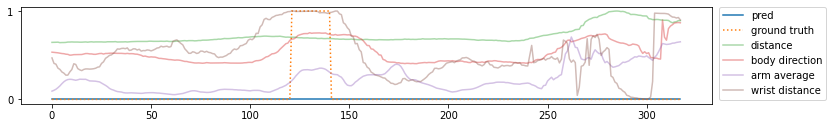

02_03_2_7


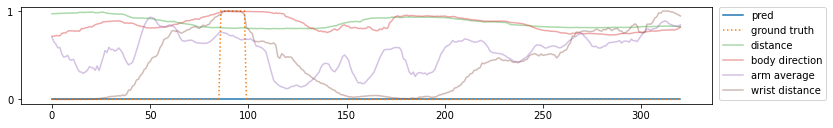

08_31_3_15


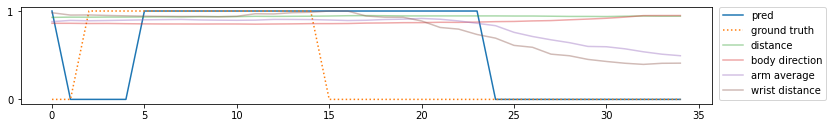

09_08_0_4


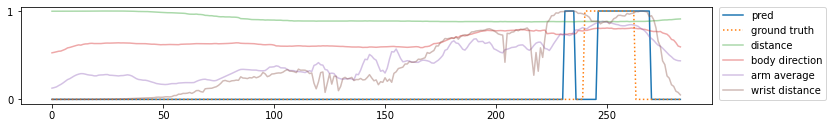

08_32_0_1


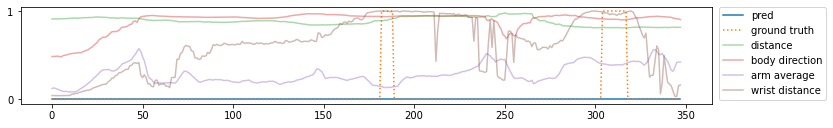

08_12_3_5


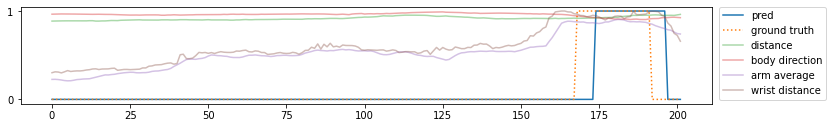

02_15_23_59


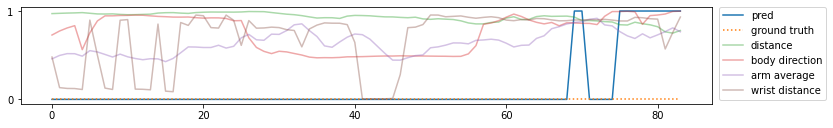

02_18_0_4


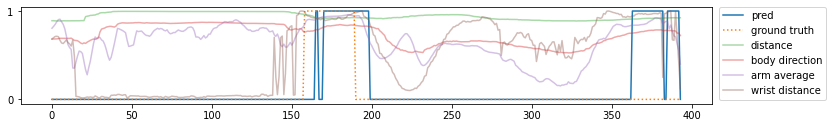

08_34_0_2


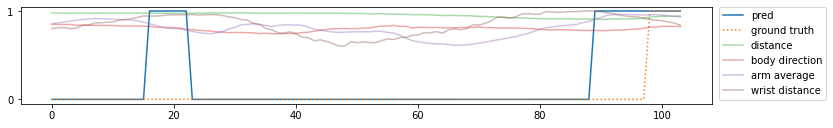

08_38_0_1


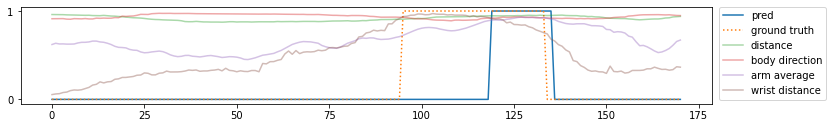

08_37_1_6


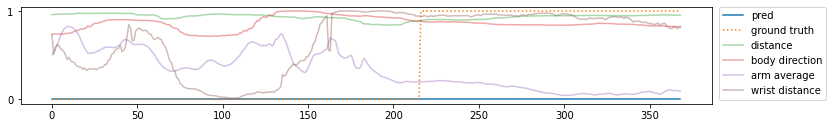

02_15_23_40


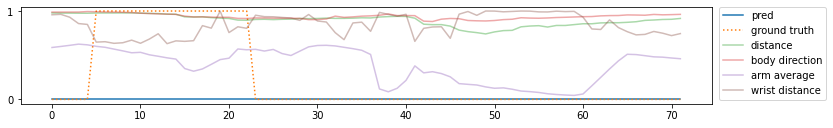

08_19_3_4


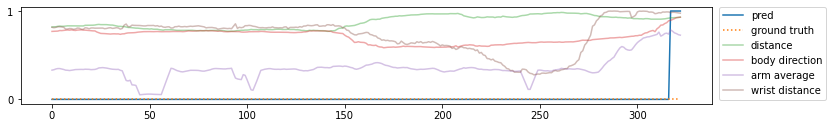

02_11_10_17


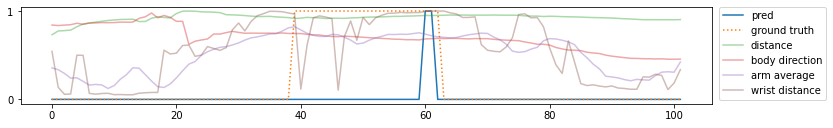

08_13_2_3


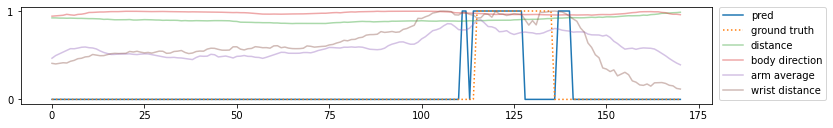

08_29_0_2


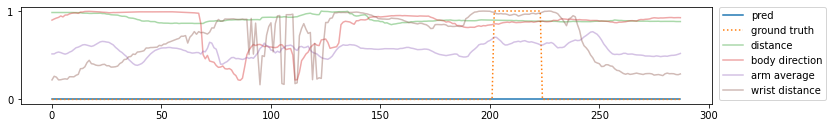

08_14_2_4


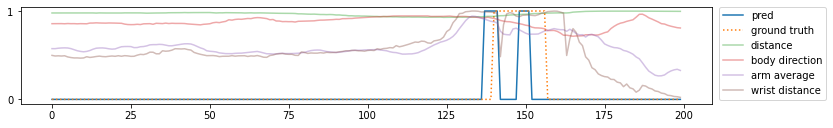

08_17_1_2


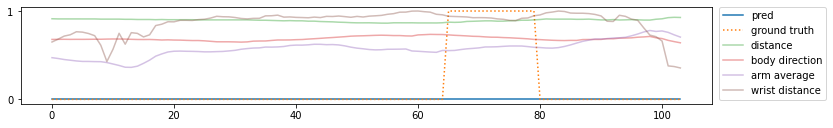

09_09_1_9


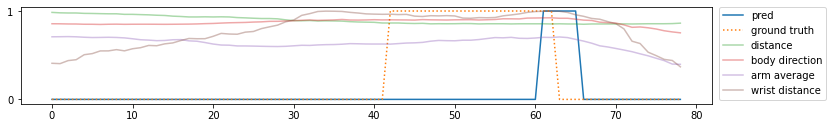

08_03_2_5


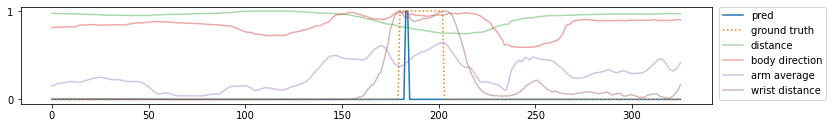

In [21]:
y_all_test = []
pred_all_test = []

model.eval()
with torch.no_grad():
    for key in test_keys:
        x_lst = np.array(x_dict[key])
        y_lst = y_dict[key]

        x, _ = create_sequence(x_lst, y_lst, **config)
        x = torch.Tensor(x).float().to(device)

        if len(x) == 0:
            continue
        pred = model(x)
        pred = pred.max(1)[1]
        pred = pred.cpu().numpy()

        x_lst = x_lst[SEQ_LEN - 1:]
        y_lst = y_lst[SEQ_LEN - 1:]
        
        y_all_test += y_lst
        pred_all_test += pred.tolist()
        
        if 1 not in pred and 1 not in y_lst:
            continue
            
        print(key)
        plt.figure(figsize=(10, 1.5))
        # plt.rcParams["font.size"] = 20
        # plt.rcParams["font.family"] = 'Times New Roman'
        plt.plot(pred, label='pred')
        plt.plot(y_lst, linestyle=':', label='ground truth')
        for i, x in enumerate(x_lst.T):
            plt.plot(x, alpha=0.4, label=columns[i])
        plt.ylim((-0.05, 1.05))
        plt.yticks([0, 1])
        plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
        plt.subplots_adjust(left=0.04, right=1, bottom=0.1, top=1)

        plt.show()

In [22]:
print('accuracy: {:.3f}'.format(accuracy_score(y_all_test, pred_all_test)))
print('precision: {:.3f}'.format(precision_score(y_all_test, pred_all_test)))
print('recall: {:.3f}'.format(recall_score(y_all_test, pred_all_test)))
print('f1_score: {:.3f}'.format(f1_score(y_all_test, pred_all_test)))

accuracy: 0.995
precision: 0.502
recall: 0.224
f1_score: 0.310


## モデル保存

In [23]:
path = f'{common.root}/model/checkpoint/pass_model_lstm.pth'
torch.save(model.state_dict(), path)

In [24]:
with open(f'{common.root}/model/config/pass_model_lstm.yaml', 'w') as f:
    yaml.dump(config, f)